In [1]:
%matplotlib inline

Dive Deep into Training with CIFAR10
==============================================

Hope you enjoyed playing with our demo script.
Now, you may be wandering: how exactly was the model trained?
In this tutorial, we will focus on answering this question.

Prerequisites
-------------

We assume readers have a basic understanding of ``Gluon``.
If not, we suggest you spend 60 minutes to get started with the {Gluon Crash
Course](http://gluon-crash-course.mxnet.io/index.html).

As we all know, training deep neural networks on GPUs is way faster than
training on CPU.
In the previous tutorials, we used CPU because classifying a single image is a
relatively easy task.
However, since we are about to train a model, it is strongly recommended to
use a machine with GPU(s).

<div class="alert alert-info"><h4>Note</h4><p>The rest of the tutorial walks you through the details of ``CIFAR10`` training.


Network Structure
-----------------

First, let's import the necessary libraries into python.




In [2]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


There are numerous structures for convolutional neural networks.
Here we pick a simple yet well-performing structure, ``cifar_resnet20_v1``, for the
tutorial.



In [3]:
# number of GPUs to use
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

# Get the model CIFAR_ResNet20_v1, with 10 output classes, without pre-trained weights
net = get_model('cifar_resnet20_v1', classes=10)
net.initialize(mx.init.Xavier(), ctx = ctx)

Data Augmentation and Data Loader
---------------------------------

Data augmentation is a common technique used for training. It is
base on the assumption that, for the same object, photos under different
composition, lighting condition, or color should all yield the same prediction.

Here are photos of the Golden Bridge, taken by many people,
at different time from different angles.
We can easily tell that they are photos of the same thing.

|image-golden-bridge|

We want to teach this invariance to our model, by playing "augmenting"
input image. Our augmentation transforms the image with
resizing, cropping, flipping and other techniques.

With ``Gluon``, we can create our transform function as following:



In [4]:
transform_train = transforms.Compose([
    # Randomly crop an area, and then resize it to be 32x32
    transforms.RandomResizedCrop(32),
    # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    # Randomly jitter the brightness, contrast and saturation of the image
    transforms.RandomColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    # Randomly adding noise to the image
    transforms.RandomLighting(0.1),
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

You may have noticed that most of the operations are randomized. This in effect
increases the number of different images the model sees during training.
The more data we have, the better our model generalizes over
unseen images.

On the other hand, when making prediction, we would like to remove all
random operations in order to get a deterministic result. The transform
function for prediction is:



In [5]:
transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

Note that it is important to keep the normalization step, since the
model only works well on inputs from the same distribution.

With the transform functions, we can define data loaders for our
training and validation datasets.



In [6]:
# Batch Size for Each GPU
per_device_batch_size = 128
# Number of data loader workers
num_workers = 0
# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus

# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=True).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

# Set train=False for validation data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=False).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

Optimizer, Loss and Metric
--------------------------

Optimizer improves the model during training. Here we use the popular
Nesterov accelerated gradient descent algorithm.



In [7]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [80, 160, np.inf]

# Nesterov accelerated gradient descent
optimizer = 'nag'
# Set parameters
optimizer_params = {'learning_rate': 0.1, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In the above code, ``lr_decay`` and ``lr_decay_epoch`` are not directly
used in ``trainer``. One important idea in model training is to
gradually decrease learning rate. This means the optimizer takes large
steps at the beginning, but step size becomes smaller and smaller in time.

Our plan sets the learning rate to 0.1 at the beginning, then
divide it by 10 at the 80-th epoch, then again at the 160-th epoch.
We'll use `lr_decay_epoch` in the main training loop for this purpose.

In order to optimize our model, we need a loss function.
In essence, loss functions compute the difference between predictions and the
ground-truth as a measure of model performance.
We can then take the gradients of the loss w.r.t. the weights.
Gradients points the optimizer to the direction weights should move to
improve model performance.

For classification tasks, we usually use softmax cross entropy as the
loss function.



In [8]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Metrics are similar to loss functions, but they are different in the
following aspects:

-  Metric is how we evaluate model performance. Each metric is related to a
   specific task, but independent from the model training process.
-  For classification, we usually only use one loss function to train
   our model, but we can have several metrics for evaluating
   performance.
-  Loss function can be used as a metric, but sometimes its values are hard
   to interpretate. For instance, the concept "accuracy" is
   easier to understand than "softmax cross entropy"

For simplicity, we use accuracy as the metric to monitor our training
process. Besides, we record metric values, and will print them at the
end of training.



In [9]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])

Validation
----------

Validation dataset provides us a way of monitoring the training process.
We have labels for validation data, but they are held out during training.
Instead, we use them to evaluate the models performance on unseen data
and prevent overfitting.



In [10]:
def test(ctx, val_data):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)
    return metric.get()

In order to evaluate performance, we need a metric. Then, we loop
through the validation data and predict with our model.
We'll run this function at the end of every epoch to show improvement.
over the last epoch.

Training
--------

After all the preparations, we can finally start training!
Following is the script.

<div class="alert alert-info"><h4>Note</h4><p>In order to finish the tutorial quickly, we only train for 5 epochs.
  In your experiments, we recommend setting ``epochs=240``.</p></div>



[Epoch 0] train=0.337660 val=0.445100 loss=89823.037903 time: 92.588988
[Epoch 1] train=0.472296 val=0.566800 loss=73040.360260 time: 91.287600
[Epoch 2] train=0.549559 val=0.518700 loss=63230.306084 time: 89.808323
[Epoch 3] train=0.591607 val=0.602900 loss=57642.224258 time: 91.237481
[Epoch 4] train=0.617688 val=0.719500 loss=54088.611649 time: 90.995673


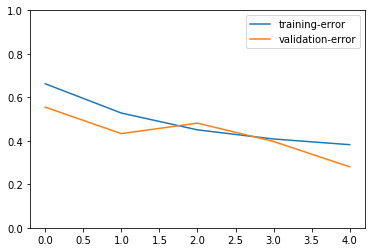

In [11]:
epochs = 5
lr_decay_count = 0


for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [net(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.sum().asscalar() for l in loss])
        train_metric.update(label, output)

    name, acc = train_metric.get()
    # Evaluate on Validation data
    name, val_acc = test(ctx, val_data)

    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc])
    print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
        (epoch, acc, val_acc, train_loss, time.time()-tic))

# We can plot the metric scores with:

train_history.plot()

If you trained the model for 240 epochs, the plot may look like:

|image-aug|

We can better observe the process of model training with plots.
For example, one may ask what will happen if there's no data augmentation:

|image-no-aug|

We can see that training error is much lower than validation error.
After the model reaches 100\% accuracy on training data,
it stops improving on validation data.
These two plots evidently demonstrates the importance of data augmentation.

Model Saving and Loading
------------------------

After training, we usually want to save it for later use.
This is simply done with:



In [12]:
net.save_params('dive_deep_cifar10_resnet20_v2.params')

Next time if you need to use it, just run



In [13]:
net.load_params('dive_deep_cifar10_resnet20_v2.params', ctx=ctx)

Next Step
---------

This is the end of our adventure with ``CIFAR10``, but there are many
more datasets and algorithms in computer vision!

If you would like to know how to train a model on a much larger dataset
than ``CIFAR10``, e.g. ImageNet, please read `ImageNet Training <dive_deep_imagenet.html>`.

Or, if you want like to know what can be done with the model you just
trained, please read the tutorial on `Transfer learning <transfer_learning_minc.html>`.

- [image-no-aug](https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/overfitting.png)
- [image-aug| image](https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/normal_training.png)
- [image-golden-bridge| image](https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/golden-bridge.png)

